# PCA Dimension Reduction

### 主成分分析の主要なステップ
#### 1. 主成分を抽出する
 - データを標準化する
 - 共分散行列を作成する
 - 共分散行列の固有値と固有ベクトル（主成分）を取得する
 - データに含まれる大半の情報（分散）を含んでいる固有ベクトル（主成分）を確認する

#### 2. 特徴変換
 - 最も大きいk個の固有値に対応するk個の固有ベクトルを選択する（kは新しい特徴部分空間の次元数を表す「k <= d」）
 - 上位k個の固有ベクトルから射影行列Wを作成する
 - 射影行列Wを使ってd次元の入力データセットXを変換し、新しいk次元の特徴部分空間を取得する

## 主成分を抽出する

### データを標準化する

In [1]:
import ssl
import sys
from pathlib import Path

sys.path.append(str(Path('__file__').resolve().parent.parent.parent.parent))
ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from src.modules.scripts.preprocessing import standardize

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

X_train = standardize(X_train)
X_test = standardize(X_test)

print('Shape of X_train (samples: {}, features: {}, mean: {:.2f}, standard: {:.2f})'.format(*X_train.shape,
                                                                                            X_train.mean(),
                                                                                            X_train.std()))
print('Shape of y_train (samples: {})'.format(*y_train.shape))
print('Shape of X_test (samples: {}, features: {}, mean: {:.2f}, standard: {:.2f})'.format(*X_test.shape, X_test.mean(),
                                                                                           X_test.std()))
print('Shape of y_test (samples: {})'.format(*y_test.shape))


Shape of X_train (samples: 124, features: 13, mean: 0.00, standard: 1.00)
Shape of y_train (samples: 124)
Shape of X_test (samples: 54, features: 13, mean: -0.00, standard: 1.00)
Shape of y_test (samples: 54)


### 共分散行列を作成する

In [2]:
cov_mat = np.cov(X_train.T)
cov_mat[0]


array([ 1.00813008,  0.06709556,  0.17405351, -0.35439069,  0.26374703,
        0.29079481,  0.21835807, -0.08111974,  0.10436705,  0.54282846,
        0.05893536, -0.01797029,  0.6415292 ])

### 共分散行列の固有値と固有ベクトル（主成分）を取得する

In [3]:
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('Eigenvalues:\n', eigen_vals, end='\n\n')
print('Eigenvectors:\n', eigen_vecs[0])


Eigenvalues:
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]

Eigenvectors:
 [-0.13724218  0.50303478 -0.13774873 -0.0032961  -0.29062523  0.29909685
  0.07905293 -0.36817641 -0.39837702 -0.09448698  0.37463888 -0.12783451
  0.26283426]


### データに含まれる大半の情報（分散）を含んでいる固有ベクトル（主成分）を確認する

In [4]:
def cal_eigenvalues_rate(eigen_vals):
    """固有値の分散説明率（固有値の合計に対する固有値の割合）を計算する.
    
    eigen_vals: 固有値
    """
    total_eigen_vals = np.sum(eigen_vals)
    var_exp = [(i / total_eigen_vals) for i in sorted(eigen_vals, reverse=True)]
    return var_exp


var_exp = cal_eigenvalues_rate(eigen_vals)
print('固有値の分散説明率（高い順）:\n', var_exp)


固有値の分散説明率（高い順）:
 [0.36951468599607656, 0.18434927059884165, 0.11815159094596973, 0.0733425176378546, 0.06422107821731673, 0.05051724484907654, 0.03954653891241441, 0.02643918316921997, 0.02389319259185292, 0.016296137737251002, 0.013800211221948425, 0.01172226244308597, 0.008206085679091393]


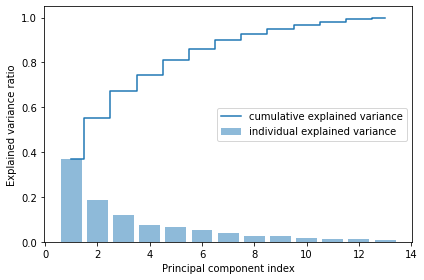

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# 分散説明率の棒グラフ
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='individual explained variance')
# 分散説明率の累積和の階段グラフ
plt.step(range(1, 14), np.cumsum(var_exp), where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


## 特徴変換

### 最も大きいk個の固有値に対応するk個の固有ベクトルを選択する（kは新しい特徴部分空間の次元数を表す「k <= d」）

In [6]:
# 固有値、固有ベクトルのタプルを作成
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
# 大きいものから順に並び替え
eigen_pairs.sort(key=lambda k: k[0], reverse=True)


### 上位k個の固有ベクトルから射影行列Wを作成する

In [7]:
# 分散説明率のグラフから主成分を3つとする
W = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis], eigen_pairs[2][1][:, np.newaxis]))
print('Matrix W:\n', W)


Matrix W:
 [[-0.13724218  0.50303478 -0.13774873]
 [ 0.24724326  0.16487119  0.09615039]
 [-0.02545159  0.24456476  0.67777567]
 [ 0.20694508 -0.11352904  0.62504055]
 [-0.15436582  0.28974518  0.19613548]
 [-0.39376952  0.05080104  0.14031057]
 [-0.41735106 -0.02287338  0.11705386]
 [ 0.30572896  0.09048885  0.13121778]
 [-0.30668347  0.00835233  0.0304309 ]
 [ 0.07554066  0.54977581 -0.07992997]
 [-0.32613263 -0.20716433  0.05305915]
 [-0.36861022 -0.24902536  0.13239103]
 [-0.29669651  0.38022942 -0.07065022]]


### 射影行列Wを使ってd次元の入力データセットXを変換し、新しいk次元の特徴部分空間を取得する

In [8]:
print('変換前のデータセット（samples: {}, features: {}）'.format(*X_train.shape))

# 線形変換する
X_train_pca = np.dot(X_train, W)
print('変換後のデータセット（samples: {}, features: {}）'.format(*X_train_pca.shape))


変換前のデータセット（samples: 124, features: 13）
変換後のデータセット（samples: 124, features: 3）


### 結果を可視化する

#### 3Dプロット

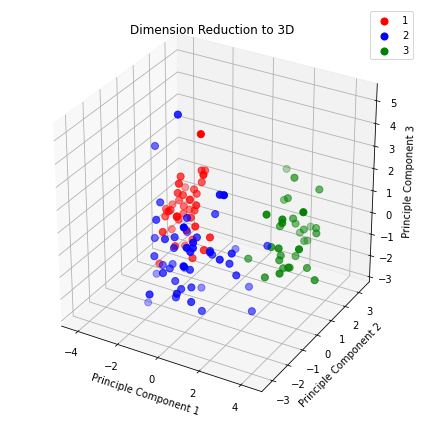

In [9]:
from mpl_toolkits.mplot3d import Axes3D

# 可視化処理
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection="3d")

colors = ['r', 'b', 'g']
for t, c in zip(np.unique(y_train), colors):
    ax.scatter3D(X_train_pca[y_train == t, 0], X_train_pca[y_train == t, 1], X_train_pca[y_train == t, 2], c=c, label=t,
                 s=50)

ax.set_title('Dimension Reduction to 3D')
ax.set_xlabel('Principle Component 1')
ax.set_ylabel('Principle Component 2')
ax.set_zlabel('Principle Component 3')
plt.tight_layout()
plt.legend()
plt.show()


#### 2Dプロット

In [10]:
# 2Dプロット用に再度線形変換する
W = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

X_train_pca = np.dot(X_train, W)
print('変換前のデータセット（samples: {}, features: {}）'.format(*X_train.shape))
print('変換後のデータセット（samples: {}, features: {}）'.format(*X_train_pca.shape))


変換前のデータセット（samples: 124, features: 13）
変換後のデータセット（samples: 124, features: 2）


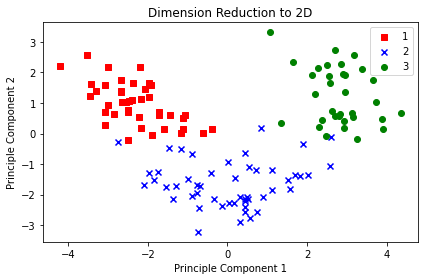

In [11]:
# 可視化処理
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for t, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == t, 0], X_train_pca[y_train == t, 1], c=c, label=t, marker=m)

plt.title('Dimension Reduction to 2D')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.tight_layout()
plt.legend()
plt.show()
